<a href="https://colab.research.google.com/github/Anderson-Lee-Git/cse447-nlp/blob/main/sample_evaluation_for_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch transformers datasets tqdm gdown==v4.6.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


# Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("openbookqa")
dataset_train, dataset_valid, dataset_test = dataset["train"], dataset["validation"], dataset["test"]
print(dataset_train)
print(dataset_valid)
print(f"first question sample: {dataset_train['question_stem'][0]}")
# Note that choices contains 'text' and 'label' keys
print(f"first choice sample: {dataset_train['choices'][0]}")
print(f"first answer key sample: {dataset_train['answerKey'][0]}")
# make sure every label ordering in choices is in order ['A', 'B', 'C', 'D']
for choice in dataset_train["choices"]:
    assert choice["label"] == ['A', 'B', 'C', 'D']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 4957
})
Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 500
})
first question sample: The sun is responsible for
first choice sample: {'text': ['puppies learning new tricks', 'children growing up and getting old', 'flowers wilting in a vase', 'plants sprouting, blooming and wilting'], 'label': ['A', 'B', 'C', 'D']}
first answer key sample: D


In [4]:
import torch
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizerFast
from datasets import load_dataset
from dataclasses import dataclass

@dataclass
class OpenQASample:
    id: str
    question_stem: str
    choices: list[str]
    labels: list[str]
    answer_key: str

    @staticmethod
    def from_dict(data: dict):
        return OpenQASample(
            id=data["id"],
            question_stem=data["question_stem"],
            choices=data["choices"],
            labels=data["labels"],
            answer_key=data["answer_key"]
        )

class OpenQADataset(Dataset):
    tokenizer: PreTrainedTokenizerFast = None

    def __init__(self, split):
        self.data = [
            OpenQASample(**{
                "id": raw_sample["id"],
                "question_stem": raw_sample["question_stem"],
                "choices": raw_sample["choices"]["text"],
                "labels": raw_sample["choices"]["label"],
                "answer_key": raw_sample["answerKey"]
            }) for raw_sample in OpenQADataset.get_openqa(split)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @staticmethod
    def get_openqa(split):
        dataset = load_dataset("openbookqa")
        return dataset[split]

    @staticmethod
    def format_question(question):
        return question

    @staticmethod
    def format_choices(choices, labels):
        for i in range(len(choices)):
            choices[i] = f"{labels[i]} - {choices[i]}"
        return choices

    @staticmethod
    def format_answer_keys(answer_keys):
        """
        Format answer keys from A, B, C, D to 0, 1, 2, 3
        :param: list of answer keys in integer
        """
        return [ord(a) - ord("A") for a in answer_keys]

    @staticmethod
    def collate_fn(batched_samples):
        B = len(batched_samples)
        batched_question = [[OpenQADataset.format_question(sample.question_stem)] * 4 for sample in batched_samples]  # B, 4
        batched_choices = [OpenQADataset.format_choices(sample.choices, sample.labels) for sample in batched_samples]  # B, 4
        batched_answer_key = [sample.answer_key for sample in batched_samples]  # B, 1
        # flatten batched_questions for tokenization
        batched_question = sum(batched_question, [])
        batched_choices = sum(batched_choices, [])
        # Tokenize the input texts.
        text_encoding = OpenQADataset.tokenizer(batched_question,
                                                batched_choices,
                                                padding=True,
                                                max_length=128,
                                                truncation=True,
                                                return_tensors="pt")
        # unflatten
        label_encoding = torch.LongTensor(OpenQADataset.format_answer_keys(batched_answer_key))  # B, 1

        return {
            "text_encoding": {k: v.view(B, 4, -1) for (k, v) in text_encoding.items()},
            "label_encoding": label_encoding,
        }

# Training


In [5]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

def compute_accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> float:
    accuracy = torch.sum(predictions == labels) / len(predictions)
    return accuracy

@torch.no_grad
def evaluate(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []
    for batch in tqdm(dataloader):
        text_encoding = batch["text_encoding"]
        for k, v in text_encoding.items():
            text_encoding[k] = v.to(model.device)
        label_encoding = batch["label_encoding"].to(model.device)
        out = model(**text_encoding, labels=label_encoding)
        logits = out.logits
        predictions = torch.argmax(logits, dim=1)
        all_predictions += predictions
        all_labels += label_encoding
    all_predictions = torch.Tensor(all_predictions)
    all_labels = torch.Tensor(all_labels)
    accuracy = compute_accuracy(all_predictions, all_labels)
    print(accuracy)

# device = "cuda"
# model = AutoModelForMultipleChoice.from_pretrained("nghuyong/ernie-1.0-base-zh").to(device)
# tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-1.0-base-zh")
# OpenQADataset.tokenizer = tokenizer
# dataset_train = OpenQADataset("train")
# dataloader_train = DataLoader(dataset=dataset_train,
#                             batch_size=128,
#                             collate_fn=OpenQADataset.collate_fn)
# print(model.num_parameters())
# evaluate(model, dataloader_train)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


## Dependencies

In [6]:
! pip install datasets
! pip install -U sentence-transformers
import torch
import random
from tqdm import tqdm
import torch.nn.functional as F
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import AdamW, set_seed
from typing import Dict, Union, List, Tuple

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.3 MB/s eta 0:00:00


## Loading Model and Tokenizer

In [7]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice, AutoModelForCausalLM, RobertaTokenizer, RobertaModel, LlamaForCausalLM, LlamaTokenizer

# model1 = AutoModelForCausalLM.from_pretrained("WizardLM/WizardLM-13B-V1.2").to(device)
# tokenizer1 = AutoTokenizer.from_pretrained("WizardLM/WizardLM-13B-V1.2")

# model2 = LlamaForCausalLM.from_pretrained("/output/path")
# tokenizer2 = LlamaTokenizer.from_pretrained("/output/path")

# tokenizer3 = RobertaTokenizer.from_pretrained('roberta-base')
model3 = AutoModelForCausalLM.from_pretrained('roberta-base').cuda()

tokenizer3 = AutoTokenizer.from_pretrained('roberta-base', padding_side = 'left')
tokenizer3.pad_token_id = tokenizer3.eos_token_id
model3.config.pad_token_id = tokenizer3.eos_token_id

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [33]:
print(dataset_train)
print(dataset_valid)
print(f"first question sample: {dataset_train['question_stem'][0]}")
# Note that choices contains 'text' and 'label' keys
print(f"first choice sample: {dataset_train['choices'][0]}")
print(f"first answer key sample: {dataset_train['answerKey'][0]}")

Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 4957
})
Dataset({
    features: ['id', 'question_stem', 'choices', 'answerKey'],
    num_rows: 500
})
first question sample: The sun is responsible for
first choice sample: {'text': ['puppies learning new tricks', 'children growing up and getting old', 'flowers wilting in a vase', 'plants sprouting, blooming and wilting'], 'label': ['A', 'B', 'C', 'D']}
first answer key sample: D


##Main methods of the Algo

In [34]:
def preprocess(dataset):
  dataset = load_dataset(dataset)
  dataset_train, dataset_valid, dataset_test = dataset["train"], dataset["validation"], dataset["test"]

  concat_prompts_train = []
  concat_prompts_valid = []
  concat_prompts_test = []

  for row in dataset_train:
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    answer = row['choices']['text'][char_count]
    question = row['question_stem']
    concat = [row['id'], question]
    for option in row['choices']['text']:
      concat.append(question + ' ' + option)
    concat.append(char_count)
    # break
    concat_prompts_train.append(concat)
    # print(row)
    # break

  for row in dataset_valid:
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    answer = row['choices']['text'][char_count]
    question = row['question_stem']
    concat = [row['id'], question]
    for option in row['choices']['text']:
      concat.append(question + ' ' + option)
    concat.append(char_count)
    # break
    concat_prompts_valid.append(concat)

  for row in dataset_test:
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    char_count = ord(row['answerKey']) - ord('A')
    # print(char_count)
    answer = row['choices']['text'][char_count]
    question = row['question_stem']
    concat = [row['id'], question]
    for option in row['choices']['text']:
      concat.append(question + ' ' + option)
    concat.append(char_count)
    # break
    concat_prompts_test.append(concat)


  prompts_train = []
  prompts_valid = []
  prompts_test = []

  for row in concat_prompts_train:
      prompt = row[2:6]
      prompts_train.append(prompt)

  for row in concat_prompts_valid:
      prompt = row[2:6]
      prompts_valid.append(prompt)

  for row in concat_prompts_test:
      prompt = row[2:6]
      prompts_test.append(prompt)

  return concat_prompts_train, concat_prompts_valid, concat_prompts_test, prompts_train, prompts_valid, prompts_test



In [41]:

def train(model, optimizer, tokenizer, lr=1e-4, batch_size=1):
  global prompts_train, prompts_valid, concat_prompts_train, concat_prompts_valid
  losses = []
  # init_loss = 0
  for epoch in range(3):
    for i, prompt in enumerate(prompts_train):
      batch = prompt
      input_tokens = tokenizer(batch, truncation=True, padding=True, return_tensors='pt').to('cuda')

      # print(input_tokens)
      output = model(**input_tokens)
      log_probs = F.log_softmax(output.logits, dim=-1)
      # print(input_tokens['input_ids'].shape)
      # print(input_tokens['input_ids'])
      output_tokens = input_tokens['input_ids'][:, 1:]
      # print(output_tokens.shape)
      # print(log_probs.shape)

      chosen_log_probs = log_probs[:, :-1, :]
      # print(output_tokens.shape)
      # print(chosen_log_probs.shape)
      chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
      chosen_log_probs = chosen_log_probs.squeeze(-1)
      prob = F.softmax(torch.sum(chosen_log_probs, dim=1).detach(), dim=-1).to('cuda')
      # print(prob)
      # [ , , , ]

      target = concat_prompts_train[i][-1]
      # print('target', target, prob[target], torch.argmax(prob))

      # some loss here figure it out
      prob = prob.clone().detach().requires_grad_(True).to('cuda')

      loss = F.cross_entropy(prob, torch.tensor(target).to('cuda'))

      # if torch.argmax(F.softmax(torch.sum(chosen_log_probs, dim=1).detach(), dim=-1)) != target:
      #   print('incorrect loss', loss)
      # else:
      #   print('correct loss', loss)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      losses.append(loss.item())

  return losses

def train_batching_closed(model, optimizer, tokenizer, lr=1e-4, batch_size=1, epochs=2):
  global prompts_train, prompts_valid, concat_prompts_train, concat_prompts_valid

  losses = []
  train_accuracies = []
  open_valid_accuracies = []
  log_valid_accuracies = []

  labels = [sublist[-1] for sublist in concat_prompts_train]
  # print(concat_prompts_train)

  total_correct = 0
  total = 0
  for epoch in range(epochs):
    for i in range(0, len(prompts_train), batch_size):
      batch_prompts = prompts_train[i:i+batch_size]
      flattened_batch_prompts = [item for sublist in batch_prompts for item in sublist]

      input_tokens = tokenizer(flattened_batch_prompts, truncation=True, padding=True, return_tensors='pt').to('cuda')

      output = model(**input_tokens)
      log_probs = F.log_softmax(output.logits, dim=-1)

      output_tokens = input_tokens['input_ids'][:, 1:]

      chosen_log_probs = log_probs[:, :-1, :]

      chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
      chosen_log_probs = chosen_log_probs.squeeze(-1)
      prob = F.softmax(torch.mean(chosen_log_probs, dim=1), dim=-1).to('cuda')
      prob = (prob.view(len(batch_prompts), 4))


      target = labels[i:i+batch_size]
      target = torch.tensor(target).to('cuda')

      predictions = torch.argmax(prob, dim =1)
      matching_mask = target == predictions

      num_matches = torch.sum(matching_mask).item()
      total_correct += num_matches
      total += len(matching_mask)

      prob = prob.requires_grad_(True)

      loss = F.cross_entropy(prob, target, reduction='mean')

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

    print('percent accuracy', total_correct/total)
    train_accuracies.append(total_correct/total)
    log_acc = evaluate_log_likelihood(model, optimizer, tokenizer, prompts_valid, concat_prompts_valid, batch_size=batch_size)
    log_valid_accuracies.append(log_acc)
    open_acc = evaluate_open_gen(model, similarity_model, tokenizer, concat_prompts_valid, max_new_tokens = 20, batch_size = batch_size)
    open_valid_accuracies.append(open_acc)
    total_correct = 0
    total = 0

  return losses, train_accuracies, log_valid_accuracies, open_valid_accuracies

In [36]:
concat_prompts_train, concat_prompts_valid, concat_prompts_test, prompts_train, prompts_valid, prompts_test = preprocess("openbookqa")


In [47]:
optimizer = AdamW(model3.parameters(), lr=1e-4)
# NOTE TO RISHI MAKE SURE YOU RUN THE EVALUATION BLOCKS BEFORE RUNNING TRAIN OR ITLL FAIL
losses, train_accuracies, log_valid_accuracies, open_valid_accuracies = train_batching_closed(model3, optimizer, tokenizer3, batch_size = 16, epochs = 15)
print(losses)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


percent accuracy 0.49485575953197497
percent accuracy 0.422
500
2000
Accuracy: 0.26
percent accuracy 0.4986887230179544
percent accuracy 0.414
500
2000
Accuracy: 0.228
percent accuracy 0.48133951987088963
percent accuracy 0.416
500
2000
Accuracy: 0.252
percent accuracy 0.5059511801492839
percent accuracy 0.422
500
2000
Accuracy: 0.224
percent accuracy 0.5105910833165221
percent accuracy 0.426
500
2000
Accuracy: 0.226
percent accuracy 0.5101876134758927
percent accuracy 0.426
500
2000
Accuracy: 0.222
percent accuracy 0.5103893483962074
percent accuracy 0.414
500
2000
Accuracy: 0.228
percent accuracy 0.5097841436352633
percent accuracy 0.418
500
2000
Accuracy: 0.236
percent accuracy 0.5103893483962074
percent accuracy 0.414
500
2000
Accuracy: 0.226
percent accuracy 0.5115997579180956
percent accuracy 0.418
500
2000
Accuracy: 0.238
percent accuracy 0.5136171071212426
percent accuracy 0.416
500
2000
Accuracy: 0.244
percent accuracy 0.5105910833165221
percent accuracy 0.412
500
2000
Accurac

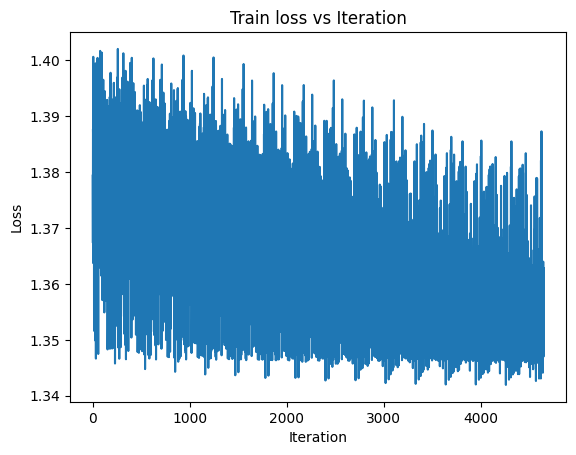

In [51]:
from matplotlib import pyplot as plt
# plot_train = [loss.detach for loss in train_losses]
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train loss vs Iteration')
plt.show()

[0.49485575953197497, 0.4986887230179544, 0.48133951987088963, 0.5059511801492839, 0.5105910833165221, 0.5101876134758927, 0.5103893483962074, 0.5097841436352633, 0.5103893483962074, 0.5115997579180956, 0.5136171071212426, 0.5105910833165221, 0.5105910833165221, 0.5103893483962074, 0.5120032277587251]
[0.422, 0.414, 0.416, 0.422, 0.426, 0.426, 0.414, 0.418, 0.414, 0.418, 0.416, 0.412, 0.418, 0.43, 0.424]
[0.26, 0.228, 0.252, 0.224, 0.226, 0.222, 0.228, 0.236, 0.226, 0.238, 0.244, 0.23, 0.234, 0.266, 0.226]


Text(0, 0.5, 'accuracy')

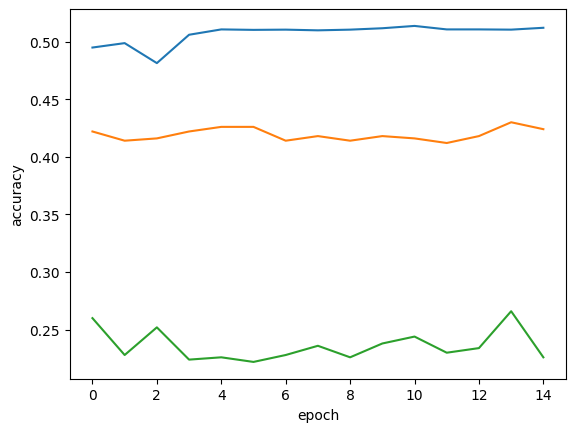

In [49]:
print(train_accuracies)
print(log_valid_accuracies)
print(open_valid_accuracies)
plt.plot(train_accuracies)
plt.plot(log_valid_accuracies)
plt.plot(open_valid_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot('Accuracy vs Epoch')

## Fine-tuning


In [18]:
dataset2 = load_dataset('sciq')
sci_dataset_train2, sci_dataset_valid2, sci_dataset_test2 = dataset2["train"], dataset2["validation"], dataset2["test"]

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
print(sci_dataset_train2[0])

{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [ ]:
import numpy as np
import random
def preprocess_finetune_sqi(dataset):
  dataset_train, dataset_valid, dataset_test = dataset['train'], dataset['validation'], dataset['test']

  new_prompts_train = [row['question'] + ' Evidence: ' + row['support'] for row in dataset_train]
  new_prompts_valid = [row['question'] + ' Evidence: ' + row['support'] for row in dataset_valid]

  concat_prompts_train = []
  concat_prompts_valid = []

  id = 0
  for i, row in enumerate(dataset_train):
    concat = [id, new_prompts_train[i]]
    correct_answer = row['correct_answer']
    distractors = []

    for num in range(1,4):
      distractors.append('Answer: ' + row['distractor' + str(num)])
    distractors.append('Answer: ' + str(correct_answer))

    random.shuffle(distractors)
    answer = distractors.index('Answer: ' + str(correct_answer))

    # now want to include all the shuffled options the index of the answer and the prompt
    # the shuffled options need to be appended to the prompt
    for option in distractors:
      concat.append(concat[1] + ' ' + option)
    concat.append(answer)
    id += 1

    concat_prompts_train.append(concat)

  # id = 0
  for i, row in enumerate(dataset_valid):
    concat = [id, new_prompts_valid[i]]
    correct_answer = row['correct_answer']
    distractors = []

    for num in range(1,4):
      distractors.append('Answer: ' + row['distractor' + str(num)])
    distractors.append('Answer: ' + str(correct_answer))
    # print('options', options, distractors)

    random.shuffle(distractors)
    answer = distractors.index('Answer: ' + str(correct_answer))

    # now want to include all the shuffled options the index of the answer and the prompt
    # the shuffled options need to be appended to the prompt
    for option in distractors:
      concat.append(concat[1] + ' ' + option)
    concat.append(answer)
    id += 1
    concat_prompts_valid.append(concat)


  prompts_train = []
  prompts_valid = []

  for row in concat_prompts_train:
      prompt = row[2:6]
      prompts_train.append(prompt)

  for row in concat_prompts_valid:
      prompt = row[2:6]
      prompts_valid.append(prompt)

  return concat_prompts_train, concat_prompts_valid, prompts_train, prompts_valid

In [ ]:
concat_prompts_train, concat_prompts_valid, prompts_train, prompts_valid = preprocess_finetune_sqi(dataset2)

In [ ]:
print(concat_prompts_train[0])

[0, 'What type of organism is commonly used in preparation of foods such as cheese and yogurt? Evidence: Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.', 'What type of organism is commonly used in preparation of foods such as cheese and yogurt? Evidence: Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine. Answer

In [ ]:
print(concat_prompts_train[0][2+1])

What type of organism is commonly used in preparation of foods such as cheese and yogurt? Evidence: Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine. Answer: mesophilic organisms


In [ ]:
print(concat_prompts_train[0][-1])

1


# Evaluation

Evaluation: log likelihood

In [38]:
def evaluate_log_likelihood(model, optimizer, tokenizer, prompts, concat_prompts, batch_size=1):
  # global prompts_train, prompts_valid, concat_prompts_train, concat_prompts_valid
  concat_prompts = [sublist[-1] for sublist in concat_prompts]
  total_correct = 0
  total = 0
  with torch.no_grad():
    for i in range(0, len(prompts), batch_size):
      batch_prompts = prompts[i:i+batch_size]
      flattened_batch_prompts = [item for sublist in batch_prompts for item in sublist]

      input_tokens = tokenizer(flattened_batch_prompts, truncation=True, padding=True, return_tensors='pt').to('cuda')

      output = model(**input_tokens)
      log_probs = F.log_softmax(output.logits, dim=-1)
      output_tokens = input_tokens['input_ids'][:, 1:]

      chosen_log_probs = log_probs[:, :-1, :]

      chosen_log_probs = torch.gather(chosen_log_probs, 2, output_tokens.unsqueeze(-1))
      chosen_log_probs = chosen_log_probs.squeeze(-1)
      prob = F.softmax(torch.mean(chosen_log_probs, dim=1), dim=-1).to('cuda')
      prob = (prob.view(len(batch_prompts), 4))


      target = concat_prompts[i:i+batch_size]
      target = torch.tensor(target).to('cuda')

      predictions = torch.argmax(prob, dim =1)
      matching_mask = target == predictions

      num_matches = torch.sum(matching_mask).item()
      total_correct += num_matches
      total += len(matching_mask)

      prob = prob.requires_grad_(True)

    print('percent accuracy', total_correct/total)
    return total_correct/total

In [23]:
evaluate_log_likelihood(model3, optimizer, tokenizer3, prompts_valid, concat_prompts_valid, batch_size = 16)

percent accuracy 0.398


0.398

Imports for open-ended generation

In [39]:
from sentence_transformers import SentenceTransformer, util

similarity_model = SentenceTransformer("all-mpnet-base-v2")

Evaluation: open-ended generation

In [40]:
def evaluate_open_gen(model, similarity_model, tokenizer, concat_prompts, max_new_tokens = 20, batch_size = 2):
  prompts = []
  for row in concat_prompts:
    prompt = row[1]
    prompts.append(prompt)
  print(len(prompts))

  answers = []
  for row in concat_prompts:
    prompt = row[2:6]
    answers.extend(prompt)

  print(len(answers))
  labels = []
  for row in concat_prompts:
    prompt = row[-1]
    labels.append(prompt)

  total_correct = 0
  total = 0
  with torch.no_grad():
    for i in range(0, len(prompts), batch_size):

      batch_prompts = prompts[i:i+batch_size]
      batch_answers = answers[4*i:4*i + (4*batch_size)]
      batch_labels = labels[i:i+batch_size]

      # tokenizes
      input_tokens_prompt = tokenizer(batch_prompts, truncation=True, padding=True, max_length = 20, return_tensors = "pt").to("cuda")

      # generates
      output_tokens_prompt = model.generate(**input_tokens_prompt, max_new_tokens = 50, do_sample= True)

      # decodes the generation to get string representation
      generated = tokenizer.batch_decode(output_tokens_prompt)


      # quadruples each generation so we can compare each to all 4 prompt+answers
      quadrupled_generated = [sublist for sublist in generated for _ in range(4)]

      # Use similarity model to compute embedding for both lists
      embeddings1 = similarity_model.encode(quadrupled_generated, convert_to_tensor=True).to(device)
      embeddings2 = similarity_model.encode(batch_answers, convert_to_tensor=True).to(device)

      # Compute cosine-similarities
      cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

      # gets only the ones we want
      diagonal_elements = torch.diag(cosine_scores)
      diagonal_elements = diagonal_elements.view(len(batch_prompts), 4)
      predicted = torch.argmax(diagonal_elements, dim=1)

      # compares with labels to get total correct
      matching_mask = predicted == torch.tensor(batch_labels).cuda()
      num_matches = torch.sum(matching_mask).item()
      total_correct += num_matches
      total += len(matching_mask)
    print("Accuracy:", total_correct/total)
    return total_correct/total

In [32]:
evaluate_open_gen(model3, similarity_model, tokenizer3, concat_prompts_valid, max_new_tokens = 20, batch_size = 2)

500
2000
['Sleet is made of a substance used to keep drinks cold', 'Sleet is made of snow and manmade materials', 'Sleet is made of small crystals of salt', 'Sleet is made of phosphates and other chemicals', 'A thin beak is most useful to allow a bird to fly faster', 'A thin beak is most useful to allow a bird to forage in trashcans for food', 'A thin beak is most useful to allow a bird to hunt for food in wide spaces', 'A thin beak is most useful to allow a bird to hunt for food in tight spaces']
Accuracy: 0.228


0.228